<a href="https://colab.research.google.com/github/lesterbogran/comparativa-deteccion-personas/blob/main/tfm_inferencias_comparativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descarga y preparacion del dataset

In [ ]:
# descarga del dataset esto puede tomar unos 15-20 minutos 
!wget  https://data.4tu.nl/ndownloader/files/24070793

--2022-01-31 04:19:55--  https://data.4tu.nl/ndownloader/files/24070793
Resolving data.4tu.nl (data.4tu.nl)... 131.180.141.15
Connecting to data.4tu.nl (data.4tu.nl)|131.180.141.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘24070793’

24070793                [            <=>     ]   9.98G  7.30MB/s    in 20m 33s 

2022-01-31 04:40:29 (8.28 MB/s) - ‘24070793’ saved [10713417760]



In [ ]:
# descompresion del dataset esto puede tomar unos 4-6 minutos
!unzip -qq ./24070793 
!ls

24070793  sample_data  wisenet_dataset


In [ ]:
import cv2
import os
import json
import pandas as pd
# Para ordenar aleatoriamente los datos
import random
random.seed(123)


In [ ]:
sets = 11
detection_dir ='wisenet_dataset/manual_annotations/people_detection/set_'
video_dir = 'wisenet_dataset/video_sets/set_'
image_dataset_dir = 'wisenet_img_dataset'

In [ ]:
!mkdir wisenet_img_dataset

In [ ]:
for i in range(1, sets+1):
  files = os.listdir(detection_dir+str(i))
  for f in files:
    f_json =  detection_dir+str(i)+"/"+f
    with open(f_json, "r") as ans:
      an = json.load(ans)
      resolution = an["resolution"][0]
      #print(f_json, resolution)

In [ ]:
def generate_images(base_dir, tags, video, set_id, video_id):
  f_json = open(tags)
  annotations = json.load(f_json)
  f_json.close()
  frames = annotations["frames"]
  resolution = annotations["resolution"][0]
  vidCap = cv2.VideoCapture(video)  
  f = -1
  list_frames =[]
  #success,image = vidCap.read()
  for frame in frames:
    fm = int(frame['frameNumber'])

    while f < fm: 
      success,image = vidCap.read()
      f +=1
    img_name = "image_video%d_%d_%d.jpg" %  (set_id, video_id, fm)
    cv2.imwrite("%s/%s" % (base_dir, img_name), image)

    dict_an = {}
    dict_an['image'] =  img_name
    dict_an['people'] = [(x['xywh'][0], x['xywh'][1], 
                          x['xywh'][0] + x['xywh'][2], x['xywh'][1] + x['xywh'][3])    
                         for x in frame['detections'] if x['class'] == 'person']
    dict_an['total'] = len(dict_an['people'])
    dict_an['resolution'] = resolution
    list_frames.append(dict_an)

  return list_frames

In [ ]:
# 12 - 15 minutos
list_frames = []
for i in range(1, sets+1):
  ad = os.listdir(detection_dir+str(i))
  vd = os.listdir(video_dir+str(i))
  #print(vd)
  for j in range(1,len(vd)+1): 
     a = "%s%d/video%d_%d.json" % (detection_dir, i, i, j)
     v = "%s%d/video%d_%d.avi" % (video_dir, i, i, j)
     print(a)
     print(v)
     frames = generate_images(image_dataset_dir, a, v, i, j)
     print(len(frames), "frames procesados")
     list_frames = list_frames + frames

wisenet_dataset/manual_annotations/people_detection/set_1/video1_1.json
wisenet_dataset/video_sets/set_1/video1_1.avi
140 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_2.json
wisenet_dataset/video_sets/set_1/video1_2.avi
895 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_3.json
wisenet_dataset/video_sets/set_1/video1_3.avi
450 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_4.json
wisenet_dataset/video_sets/set_1/video1_4.avi
1746 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_5.json
wisenet_dataset/video_sets/set_1/video1_5.avi
1749 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_2/video2_1.json
wisenet_dataset/video_sets/set_2/video2_1.avi
415 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_2/video2_2.json
wisenet_dataset/video_sets/set_2/video2_2.avi
1469 frames procesados
wisenet_dataset/m

In [ ]:
ground_truth = list_frames
random.shuffle(ground_truth)
# incluir solo las imagenes de una misma resolucion 
ground_truth = [gt for gt in ground_truth if gt['resolution'] == {'height': 720.0, 'width': 1280.0}]

# Prueba de modelos entrenados entrenados con coco 

In [ ]:
# Necesario para cargar modelos desde TF-Hub module y hacer las inferencias.
import tensorflow as tf
import tensorflow_hub as hub

# Para algunas utilidades que permitan mostrar imagenes con sus detecciones 
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from six import BytesIO

# para el manejo de los datos
import pandas as pd

# para funciones estadisticas 
from scipy import stats
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
#import statsmodels.graphics.gofplots as sm

# necesarios para la deteccion con HOG
import cv2

# Para cargar las anotaciones en formato json 
import json

# Para medir el tiempo de la inferencia 
import time

# para acceder a torch hub y descargar yolov5
import torch

In [ ]:

category_index = {
    1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 
    3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 
    5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 
    7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 
    9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 
    11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 
    14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 
    16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 
    20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 
    22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 
    24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 
    27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 
    31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 
    33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name': 'frisbee'}, 
    35: {'id': 35, 'name': 'skis'}, 36: {'id': 36, 'name': 'snowboard'}, 
    37: {'id': 37, 'name': 'sports ball'}, 38: {'id': 38, 'name': 'kite'}, 
    39: {'id': 39, 'name': 'baseball bat'}, 40: {'id': 40, 'name': 'baseball glove'}, 
    41: {'id': 41, 'name': 'skateboard'}, 42: {'id': 42, 'name': 'surfboard'}, 
    43: {'id': 43, 'name': 'tennis racket'}, 44: {'id': 44, 'name': 'bottle'}, 
    46: {'id': 46, 'name': 'wine glass'}, 47: {'id': 47, 'name': 'cup'}, 
    48: {'id': 48, 'name': 'fork'}, 49: {'id': 49, 'name': 'knife'}, 
    50: {'id': 50, 'name': 'spoon'}, 51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'}, 53: {'id': 53, 'name': 'apple'}, 
    54: {'id': 54, 'name': 'sandwich'}, 55: {'id': 55, 'name': 'orange'}, 
    56: {'id': 56, 'name': 'broccoli'}, 57: {'id': 57, 'name': 'carrot'}, 
    58: {'id': 58, 'name': 'hot dog'}, 59: {'id': 59, 'name': 'pizza'}, 
    60: {'id': 60, 'name': 'donut'}, 61: {'id': 61, 'name': 'cake'}, 
    62: {'id': 62, 'name': 'chair'}, 63: {'id': 63, 'name': 'couch'}, 
    64: {'id': 64, 'name': 'potted plant'}, 65: {'id': 65, 'name': 'bed'}, 
    67: {'id': 67, 'name': 'dining table'}, 70: {'id': 70, 'name': 'toilet'}, 
    72: {'id': 72, 'name': 'tv'}, 73: {'id': 73, 'name': 'laptop'}, 
    74: {'id': 74, 'name': 'mouse'}, 75: {'id': 75, 'name': 'remote'}, 
    76: {'id': 76, 'name': 'keyboard'}, 77: {'id': 77, 'name': 'cell phone'}, 
    78: {'id': 78, 'name': 'microwave'}, 79: {'id': 79, 'name': 'oven'}, 
    80: {'id': 80, 'name': 'toaster'}, 81: {'id': 81, 'name': 'sink'}, 
    82: {'id': 82, 'name': 'refrigerator'}, 
    84: {'id': 84, 'name': 'book'}, 85: {'id': 85, 'name': 'clock'}, 
    86: {'id': 86, 'name': 'vase'}, 87: {'id': 87, 'name': 'scissors'}, 
    88: {'id': 88, 'name': 'teddy bear'}, 89: {'id': 89, 'name': 'hair drier'}, 
    90: {'id': 90, 'name': 'toothbrush'}}

In [ ]:
faster_rcnn_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1"
faster_rcnn = hub.load(faster_rcnn_url)

In [ ]:
ssd_url = "https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1"
ssd = hub.load(ssd_url)

In [ ]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [ ]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolo.classes = [0] # solo nos interesa detectar la clase persona

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/14.0M [00:00<?, ?B/s]

In [ ]:
#
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  print(im_width, im_height)
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, classes=["person"], max_boxes=20, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      category = category_index[class_names[i]]["name"]
      if category not in classes:
        continue
      display_str = "{}: {}%".format(category,
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def load_image_into_numpy_array(path):
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def show_detections(result, img):
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"][0],
      result["detection_classes"][0].astype(int), result["detection_scores"][0])

  display_image(image_with_boxes)

In [ ]:
def run_detect(detector, img_path):
  image_np = load_image_into_numpy_array(img_path)
  # running inference
  results = detector(image_np)
  result = {key:value.numpy() for key,value in results.items()}
  return result    


In [ ]:
def get_person_detected(image, result, resolution, threshold=0.1):
  classes = result["detection_classes"][0].astype(int) 
  scores = result["detection_scores"][0]
  boxes = result["detection_boxes"][0]
  det = {"image": image}
  peo = []
  for i in range(len(classes)):
    if classes[i] == 1 and scores[i]>=threshold:
      peo.append(list(boxes[i]))
  
  im_width = resolution["width"]#1280 
  im_height = resolution["height"]#720
  
  for i in range(len(peo)):
    (ymin, xmin, ymax, xmax) = peo[i]
    peo[i]= (int(xmin * im_width),  int(ymin * im_height), int(xmax * im_width),int(ymax * im_height))

  det["people"]= peo
  det["total"] = len(peo)


  return det

def correct_hog_detections(regions):
    for i in range(len(regions)):
        (x, y, w, h) = regions[i]
        #print(x, y, w, h)
        regions[i] = (x, y, x+w, y+h)
    return regions

# Tiempo de Inferencia

In [ ]:
sgt = random.sample(ground_truth, 130)

def time_inferences(inferences, model="Modelo", print_results=False):
  t_total = 0
  t_min = inferences[0]["time"]
  t_max = 0
  for inference in inferences:
    t_total += inference["time"]
    if inference["time"] < t_min:
      t_min = inference["time"]
    if inference["time"] > t_max:
      t_max = inference["time"]
  t_avg = t_total / len(inferences)
  if print_results:
    print(model)
    print("Menor tiempo de inferencia:", t_min)
    print("Mayor tiempo de inferencia:", t_max)
    print("Tiempo total de inferencia: ", t_total)
    print("Tiempo medio de inferencia: ", t_avg)    

  return (t_total, t_max, t_min, t_avg)  

## Faster R-CNN

In [ ]:
faster_inferences = []
img_base_path = "wisenet_img_dataset/"
# la primera vez que se realiza una inferencia el modelo tarda en cargar por lo 
# que para efectos de esta prueba se realiza un inferncia de prueba para cargar
# el modelo
run_detect(faster_rcnn, img_base_path+sgt[0]['image'])

for d in sgt:
  start_time = time.time()
  result = run_detect(faster_rcnn, img_base_path+d['image'])
  end_time = time.time()
  det = get_person_detected(d['image'], result,d["resolution"])
  det['time'] = end_time-start_time
  faster_inferences.append(det)#{"image":d['image'], "result":result, "resolution":d["resolution"], "time":end_time-start_time})

tiempos = time_inferences(faster_inferences, "Faster R-CNN", True)



Faster R-CNN
Menor tiempo de inferencia: 1.2388365268707275
Mayor tiempo de inferencia: 1.364365816116333
Tiempo total de inferencia:  165.6929750442505
Tiempo medio de inferencia:  1.2745613464942345


## SSD

In [ ]:
ssd_inferences = []
run_detect(ssd, img_base_path+sgt[0]['image'])
for d in sgt:
  start_time = time.time()
  result = run_detect(ssd, img_base_path+d['image'])
  end_time = time.time()
  det = get_person_detected(d['image'], result,d["resolution"])
  det['time'] = end_time-start_time
  ssd_inferences.append(det)#{"image":d['image'], "result":result, "resolution":d["resolution"], "time":end_time-start_time})

tiempos = time_inferences(ssd_inferences, "SSD", True)

SSD
Menor tiempo de inferencia: 1.290156602859497
Mayor tiempo de inferencia: 1.4140453338623047
Tiempo total de inferencia:  172.41064858436584
Tiempo medio de inferencia:  1.3262357583412758


## HOG

In [ ]:
def run_hog_detect(img):
  test = cv2.imread(img)
  return hog.detectMultiScale(test)


In [ ]:
# hog no tiene el problema de la carga
hog_inferences = []
for d in sgt:
  start_time = time.time()
  (regions, _) = run_hog_detect(img_base_path+d['image'])
  end_time = time.time()
  regs = correct_hog_detections(regions)
  hog_inferences.append({"image":d['image'], "people":regs, "total": len(regs), "time":end_time-start_time})


tiempos = time_inferences(hog_inferences, "HOG", True)

HOG
Menor tiempo de inferencia: 0.6247243881225586
Mayor tiempo de inferencia: 0.706587553024292
Tiempo total de inferencia:  83.46585059165955
Tiempo medio de inferencia:  0.6420450045512273


## YOLO

In [ ]:
yolo_inferences = []
results = yolo([img_base_path+sgt[0]['image']])

for d in sgt:
  start_time = time.time()
  results = yolo([img_base_path+d['image']])
  end_time = time.time()
  people = []
  cuadros = results.pandas().xyxy[0].to_dict(orient="records")
  for c in cuadros:
    people.append([int(c['xmin']), int(c['ymin']), int(c['xmax']), int(c['ymax'])])
  yolo_inferences.append({"image":d['image'], "people":people, "total":len(people),"time":end_time-start_time})

tiempos = time_inferences(yolo_inferences, "YOLO", True)

YOLO
Menor tiempo de inferencia: 0.019646406173706055
Mayor tiempo de inferencia: 0.04247879981994629
Tiempo total de inferencia:  3.052029848098755
Tiempo medio de inferencia:  0.02347715267768273


In [ ]:
def print_image_times(model, inferences):
  #print(model)
  tiempos = []
  for inference in inferences:
    tiempos.append({'nivel':model, 'tiempo':inference['time']})
    print(f"{model},{inference['time']}")
    #tiempos.append(inference['time'])
  return tiempos
  #print("\n")
print("Nivel,Tiempo")

tiempos = print_image_times("Faster R-CNN", faster_inferences)
tiempos += print_image_times("SSD", ssd_inferences)
tiempos += print_image_times("HOG", hog_inferences)
tiempos += print_image_times("YOLO", yolo_inferences)

Nivel,Tiempo
Faster R-CNN,1.320105791091919
Faster R-CNN,1.2602062225341797
Faster R-CNN,1.293102741241455
Faster R-CNN,1.2765913009643555
Faster R-CNN,1.2667651176452637
Faster R-CNN,1.2748587131500244
Faster R-CNN,1.2907307147979736
Faster R-CNN,1.2985858917236328
Faster R-CNN,1.2695870399475098
Faster R-CNN,1.3183581829071045
Faster R-CNN,1.3330738544464111
Faster R-CNN,1.270740270614624
Faster R-CNN,1.280796766281128
Faster R-CNN,1.2778711318969727
Faster R-CNN,1.2666466236114502
Faster R-CNN,1.3261706829071045
Faster R-CNN,1.2519032955169678
Faster R-CNN,1.3103053569793701
Faster R-CNN,1.3233091831207275
Faster R-CNN,1.2655177116394043
Faster R-CNN,1.310687780380249
Faster R-CNN,1.2870211601257324
Faster R-CNN,1.2624695301055908
Faster R-CNN,1.3145818710327148
Faster R-CNN,1.2684013843536377
Faster R-CNN,1.2531521320343018
Faster R-CNN,1.2613022327423096
Faster R-CNN,1.2673475742340088
Faster R-CNN,1.251162052154541
Faster R-CNN,1.2654781341552734
Faster R-CNN,1.2881131172180176
F

# Precisión de los modelos

In [ ]:
def intersection_over_union(boxA, boxB):
  # tomado de https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# calcula el area de interseccion
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# calcula el area de la prediccion y ground-truth
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# devueve el valor de la  IOU (intersection over union)
	return iou

In [ ]:
def iou_per_inference(pr, gt):
  # en esta primera parte se calcula el iou de todas las cajas 
  # detectadas y en resultado se guarda junto con 
  # el indice de la caja en el ground truth
  # en este punto solo se verifica que exista un valor de iou mayor a 0
  result =[]
  for i in range(len(pr)):
    box1 = pr[i]
    for j in range(len(gt)):
      box2 = gt[j]
      iou = intersection_over_union(box1, box2)
      if iou > 0 :
        result.append((j, iou, i))

  # en esta segunda parte se verifican los posibles traslapes ya que esto 
  # puede ocacionar que se realice una doble deteccion es decir que una misma
  # caja en el ground truth haya sido detectada dos veces si ese es el caso
  # por simplicidad se tomará el que tenga el iou mas alto y a los demas 
  # se les asignara 0
  best_matches = []
  for i in range(len(result)):
    f1 = result[i]
    max_index_iou = i
    max_iou = f1[1]
    for j in range(len(result)):
      f2 = result[j]
      if f1[0] == f2[0]:
        if f2[1] > max_iou:
          max_index_iou = j
          max_iou = f2[1]
    if max_index_iou not in best_matches:
      best_matches.append(max_index_iou) 
  #print(len(result), len(pr))

  # esta seccion es donde se verifica solo las mejores coincidencias 
  ious = [0 for i in range(len(pr))]
  for i in range(len(result)):
    if i in best_matches:
      index_gt = result[i][2]
      #print(index_gt)
      ious[index_gt] = result[i][1] 

  return ious
      


def iou_for_all_inferences(pr, gt):
  # en cada inferencia puede haber mas de una deteccion
  # por cada deteccion se calcula el iou
  results = []
  for i in range(len(pr)):
    r = pr[i]
    img = {"image": r['image']}
    img["boxes_iou"] = iou_per_inference(r['people'], gt[i]['people'])
    img["expected"] = len(gt[i]['people'])
    img["detected"] = len(r['people'])
    results.append(img)
  return results 

In [ ]:
def calculate_TF_PN_Img(iou, threshold=0.3):
  TP = 0
  FP = 0
  TD = iou['detected']
  GT = iou['expected']
  deteciones = []
  for box in iou['boxes_iou']:
    if box >= threshold:
      TP += 1
    else:
      FP += 1  
  return {"TP": TP, "FP": FP, "TD": TD, "GT": GT}

In [ ]:
def calculate_TF_PN(ious, threshold=0.3):
  TP = 0
  FP = 0
  TD = 0 
  GT = 0
  for iou in ious:
    TD += iou['detected']
    GT += iou['expected']
    for box in iou['boxes_iou']:
      if box >= threshold:
        TP += 1
      else:
        FP += 1
  return {"TP": TP, "FP": FP, "FN": GT-TP, "TD": TD, "GT": GT}

In [ ]:
def calculate_precision(res):
  return res['TP']/res['TD']

def calculate_recall(res):
  return res['TP']/res['GT']

def calculate_P_R(ious):
  tf_pn = calculate_TF_PN(ious)
  return (calculate_precision(tf_pn),calculate_recall(tf_pn))

In [ ]:
faster_ious = iou_for_all_inferences(faster_inferences, sgt)
ssd_ious = iou_for_all_inferences(ssd_inferences, sgt)
hog_ious = iou_for_all_inferences(hog_inferences, sgt)
yolo_ious = iou_for_all_inferences(yolo_inferences, sgt)


In [ ]:
print("Faster", calculate_TF_PN(faster_ious))
print("SSD", calculate_TF_PN(ssd_ious))
print("HOG", calculate_TF_PN(hog_ious))
print("YOLO", calculate_TF_PN(yolo_ious))

Faster {'TP': 166, 'FP': 65, 'FN': 36, 'TD': 231, 'GT': 202}
SSD {'TP': 185, 'FP': 258, 'FN': 17, 'TD': 443, 'GT': 202}
HOG {'TP': 73, 'FP': 188, 'FN': 129, 'TD': 261, 'GT': 202}
YOLO {'TP': 167, 'FP': 16, 'FN': 35, 'TD': 183, 'GT': 202}


In [ ]:
print("Faster Precision(%f) Recall(%f)" % calculate_P_R(faster_ious))
print("SSD Precision(%f) Recall(%f)" % calculate_P_R(ssd_ious))
print("HOG Precision(%f) Recall(%f)" % calculate_P_R(hog_ious))
print("YOLO Precision(%f) Recall(%f)" % calculate_P_R(yolo_ious))

Faster Precision(0.718615) Recall(0.821782)
SSD Precision(0.417607) Recall(0.915842)
HOG Precision(0.279693) Recall(0.361386)
YOLO Precision(0.912568) Recall(0.826733)


# Estimación de errores

In [ ]:
import sklearn.metrics as metrics 

In [ ]:
y_true = [x['total']for x in sgt]
faster_detected = [x['detected'] for x in faster_ious]
ssd_detected = [x['detected'] for x in ssd_ious]
hog_detected = [x['detected'] for x in hog_ious]
yolo_detected = [x['detected'] for x in yolo_ious]


print("FASTER R-CNN")
print("MSE:", metrics.mean_squared_error(y_true, faster_detected))
print("RMSE:", metrics.mean_squared_error(y_true, faster_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, faster_detected))

print("SSD")
print("MSE:", metrics.mean_squared_error(y_true, ssd_detected))
print("RMSE:", metrics.mean_squared_error(y_true, ssd_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, ssd_detected))

print("HOG")
print("MSE:", metrics.mean_squared_error(y_true, hog_detected))
print("RMSE:", metrics.mean_squared_error(y_true, hog_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, hog_detected))


print("YOLO")
print("MSE:", metrics.mean_squared_error(y_true, yolo_detected))
print("RMSE:", metrics.mean_squared_error(y_true, yolo_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, yolo_detected))


FASTER R-CNN
MSE: 0.7615384615384615
RMSE: 0.8726617108241094
MAE: 0.5923076923076923
SSD
MSE: 7.6692307692307695
RMSE: 2.769337604776776
MAE: 1.9307692307692308
HOG
MSE: 2.2846153846153845
RMSE: 1.5114944209673367
MAE: 1.1307692307692307
YOLO
MSE: 0.2076923076923077
RMSE: 0.45573271518765
MAE: 0.2076923076923077


# Analisis de los resultados

In [ ]:
df = pd.DataFrame.from_records(tiempos)

In [ ]:
kruscal = scipy.stats.kruskal(*[group["tiempo"].values for name, group in df.groupby("nivel")])
kruscal

KruskalResult(statistic=472.47244818647556, pvalue=4.40510283190582e-102)

In [ ]:
kstest = scipy.stats.kstest(df["tiempo"].values, 'norm')
kstest

KstestResult(statistic=0.5078372779036344, pvalue=8.161267518928292e-125)

In [ ]:
f_oneway = scipy.stats.f_oneway(*[group["tiempo"].values for name, group in df.groupby("nivel")])
f, p = f_oneway

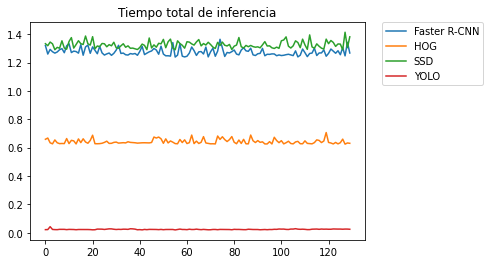

In [ ]:
%matplotlib inline
data = np.array([group["tiempo"].values for name, group in df.groupby("nivel")])
data = pd.DataFrame(data)
data = [{name: group["tiempo"].values}  for name, group in df.groupby("nivel")]

df2 = pd.DataFrame()
for d in data:
  for k, v in d.items():
    df2[k] = v

plt.plot(df2)
plt.title("Tiempo total de inferencia")
plt.legend(list(df2.columns.values), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()